In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%load_ext version_information
%version_information numpy, dlib, matplotlib, imageio, gaze, torch, torchvision

Software,Version
Python,3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]
IPython,7.0.1
OS,Darwin 18.0.0 x86_64 i386 64bit
numpy,1.15.2
dlib,19.16.0
matplotlib,3.0.0
imageio,2.4.1
gaze,The 'gaze' distribution was not found and is required by the application
torch,0.4.1
torchvision,0.2.1


# training the model on the cropped faces

In [4]:
from gaze import init

In [5]:
args = init(verbose=1)
path = '_Regard.pt'

In [6]:
epochs = 400
args = init(verbose=1, epochs=epochs)

path = '_Regard_400.pt'

In [9]:
print('Parameters=', args)
!ls -l {path}

Parameters= {'dataset_folder': 'dataset', 'dataset_faces_folder': 'dataset_faces', 'batch_size': 8, 'test_batch_size': 1, 'size_test_set': 0.2, 'epochs': 400, 'do_adam': False, 'lr': 0.025, 'momentum': 0.05, 'no_cuda': True, 'num_processes': 1, 'seed': 42, 'log_interval': 0, 'fullsize': 75, 'crop': 64, 'size': 64, 'mean': 0.4, 'std': 0.3, 'conv1_dim': 9, 'conv1_kernel_size': 18, 'conv2_dim': 36, 'conv2_kernel_size': 14, 'conv1_bn_momentum': 0.9, 'conv2_bn_momentum': 0.9, 'dense_bn_momentum': 0.9, 'stride1': 2, 'stride2': 4, 'N_cv': 4, 'dimension': 30, 'verbose': 0, 'classes': ['blink', 'center', 'left', 'right']}
ls: _Regard_400.pt: No such file or directory


In [10]:
from gaze import ML
ml = ML(args)
ml.train(path=path)

Training model...
Model saved at _Regard_400.pt


## testing the model

In [11]:
Accuracy = ml.test()
print('Accuracy={:.1f}%'.format(Accuracy*100))

Accuracy=93.0%


Showing the one which are wrong:

## showing the images which are wrongly classified

In [12]:
import time
import os
import glob
import imageio
from gaze import FaceExtractor
FE = FaceExtractor()
timings = []
wrongs = []
for target in ml.dataset.classes:
    for filename in glob.glob(os.path.join(args.dataset_folder, target) + '/*.png'):
        if False:
            frame = imageio.imread(filename)
            img_face = FE.face_extractor(frame)
        else:
            filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)
            img_face = imageio.imread(filename_face)

        pred = ml.classify(img_face, ml.dataset.test_transform)
        pred_label = ml.dataset.dataset.classes[pred.argmax()]
        if not pred_label == target:
            wrong = dict(filename=filename, pred_label=pred_label, target=target)
            wrongs.append(wrong)
            print('For ', filename, ', Pred =', pred_label, 'True =', target, ', P=', ['%.3f' % p for p in pred])
            #plt.imshow(img_face)
            #plt.show()

For  dataset/blink/2018-10-15_Laurent_209.png , Pred = left True = blink , P= ['0.187', '0.000', '0.813', '0.000']
For  dataset/blink/2018-09-05_Laurent_164.png , Pred = right True = blink , P= ['0.496', '0.000', '0.000', '0.504']
For  dataset/center/2018-10-12_Laurent_121.png , Pred = right True = center , P= ['0.000', '0.255', '0.000', '0.745']
For  dataset/center/2018-10-14_Laurent_180.png , Pred = left True = center , P= ['0.002', '0.155', '0.840', '0.003']
For  dataset/center/2018-10-15_Laurent_091.png , Pred = left True = center , P= ['0.000', '0.000', '1.000', '0.000']
For  dataset/center/2018-10-15_Laurent_132.png , Pred = left True = center , P= ['0.000', '0.000', '1.000', '0.000']
For  dataset/center/2018-10-14_Laurent_225.png , Pred = right True = center , P= ['0.000', '0.004', '0.045', '0.951']
For  dataset/center/2018-10-12_Laurent_234.png , Pred = right True = center , P= ['0.000', '0.092', '0.035', '0.873']
For  dataset/center/2018-10-14_Laurent_241.png , Pred = left Tru

## skim through images which were wrongly classified

Some images were obviously misclassified at the supervision level, let's try to fix that.

In [13]:
def view_image(wrong):
    filename = wrong['filename']
    filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)
    img_face = imageio.imread(filename_face)
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.imshow(img_face)
    ax.set_title('Pred: %s / True: %s ' % (wrong['pred_label'], wrong['target']))
    #plt.show()


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive
def f(i, action):
    wrong = wrongs[i]
    view_image(wrong)
    filename = wrong['filename']
    filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)

    if action == 'Remove':
        print('removing...', filename)
        os.remove(filename_face)
        os.remove(filename)
    elif action == 'Change':
        print('Changing...', filename, ' to ', filename.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        import shutil
        shutil.move(filename, filename.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        shutil.move(filename_face, filename_face.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        wrongs[i]['filename'] = filename.replace(wrongs[i]['target'], wrongs[i]['pred_label'])
        wrongs[i]['target'] = wrongs[i]['pred_label']
        
    #display(b)
    return action

w = interactive(f, i=widgets.IntSlider(min=0, max=len(wrongs)-1, step=1, value=0, readout=False), action=widgets.ToggleButtons(options=['Keep', 'Remove', 'Change']))
display(w)

interactive(children=(IntSlider(value=0, description='i', max=26, readout=False), ToggleButtons(description='a…

## showing the trained weights

https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/README.md


In [14]:
child = ml.model.children()

convolayer = [i for i in ml.model.children()][1]
convolayer

weights = convolayer.weight.data.clone()
weights.shape

torch.Size([9])

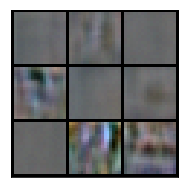

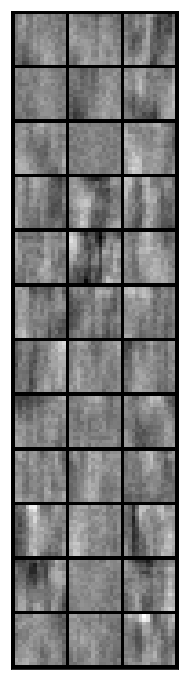

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision import utils

def plotkernel(tensor, figname, ch=0, allkernels=False, nrow=3, padding=1):
    n, c, w, h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    fig, ax = plt.subplots( figsize=(nrow,rows))
    ax.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.setp(ax, xticks=[], yticks=[])

    plt.savefig(figname)

for i, weights in enumerate([ml.model.conv1.weight.data.clone(), ml.model.conv2.weight.data.clone()]):
    plotkernel(weights, figname = 'figures/kernel_layer' + str(i) + '.png')

    